## Task 1: Introduction

Starter notebook for the Coursera Guided Project [Creating Multi Task Models With Keras](https://www.coursera.org/projects/multi-task-models-keras)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

%matplotlib inline
%load_ext tensorboard

try:
  shutil.rmtree('logs')
except:
  pass

## Task 2: Create Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
def create_example(x, y):
    c = np.random.randint(0, 2)
    image = 0.5 * np.random.rand(28, 28, 3)
    image[:, :, c] += 0.5 * x / 255
    return image, y, c

digit: 5, color: green


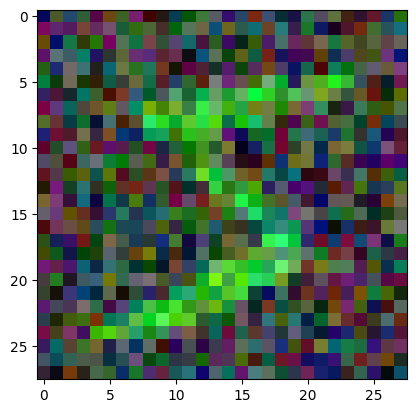

In [12]:
colours = {0 : 'red', 1 : 'green'}

x, y, c = create_example(x_train[0], y_train[0])

print(f'digit: {y}, color: {colours[c]}')

plt.imshow(x)

plt.show()

## Task 3: Dataset Generator

In [13]:
def generate_data(x, y, batch_size=32):
    num_examples = len(y)
    
    while True:
        x_batch = np.zeros((batch_size, 28, 28, 3))
        y_batch = np.zeros((batch_size,))
        c_batch = np.zeros((batch_size,))
        
        for i in range(0, batch_size):
            index = np.random.randint(0, num_examples)
            image, digit, color = create_example(x[index], y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color
        
        yield x_batch, [y_batch, c_batch]
        

In [27]:
x, [y, c] = next(generate_data(x_test, y_test, batch_size=3))

9.0 0.0


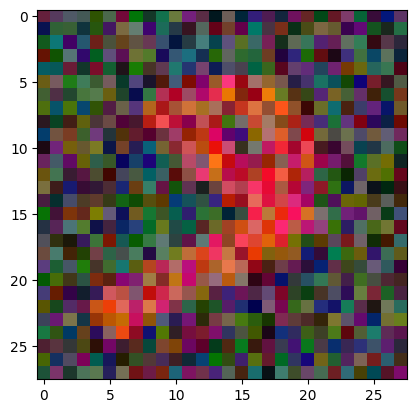

In [28]:
print(y[2], c[2])
plt.imshow(x[2]);

## Task 4: Create Model

## Task 5: Training the Model

In [ ]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [ ]:
%tensorboard --logdir logs

## Task 6: Final Predictions

In [ ]:
def test_model(show=True):
  x, [y, c] = next(test)

  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])

  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)